# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

It is strongly recommended to use Google Colab (with a GPU) to run this notebook. This will drastically speed up computations.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('images.png') #Replace "image.jpg" with the path of your image
plt.imshow(img)
plt.axis('off')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'images.png'

In [6]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras.datasets import cifar10
#from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [7]:
################## TODO BLOCK

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

################## END TODO BLOCK

170498071/170498071 [==============================] - 6s 0us/step


**2) Check the shape of images and targets.**

In [8]:
################## TODO BLOCK


print("The shape of the images is", np.shape(x_train[0]))
print("The shape of the labels is", np.shape(y_train[0]))

################## END TODO BLOCK

The shape of the images is (32, 32, 3)
The shape of the labels is (1,)


In [9]:
np.shape(y_train)

(50000, 1)

**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [10]:
################## TODO BLOCK

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

################## END TODO BLOCK

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [11]:
################## TODO BLOCK

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255

################## END TODO BLOCK

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [12]:
################## TODO BLOCK

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

################## END TODO BLOCK

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

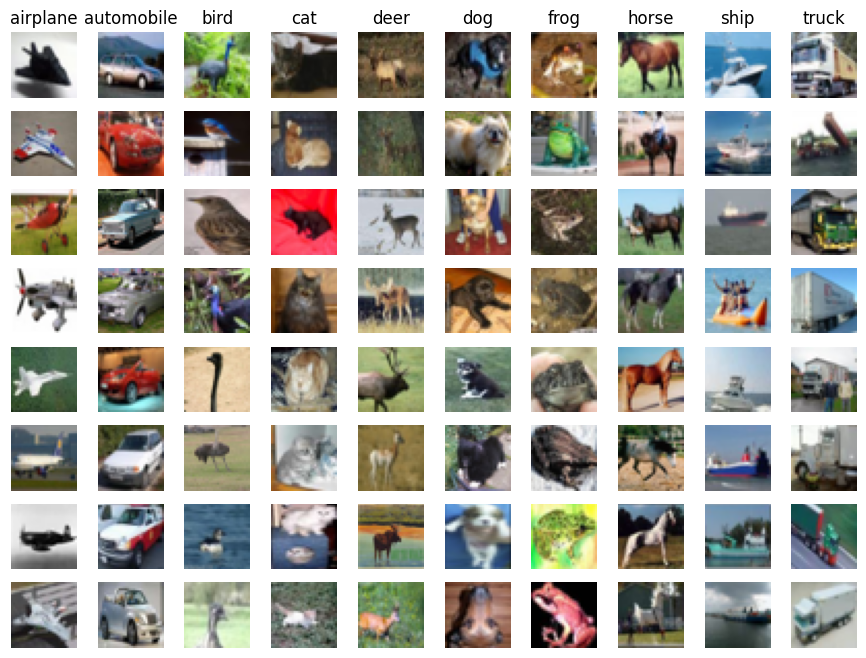

In [13]:
################## TODO BLOCK

n, images, categories, labels = 8, x_train, y_train, labels

f, axes = plt.subplots(n, 10, figsize=(11,8))

for i in range(10):
    count = 0
    j = 0
    while count < n and j < 50000:
        if categories[j][i] == 1:
            axes[count,i].imshow(images[j,:,:,:])
            axes[count,i].axis('off')
            if count == 0:
                axes[count,i].set_title(labels[i])
            count += 1
        j += 1
plt.show()

################## END TODO BLOCK

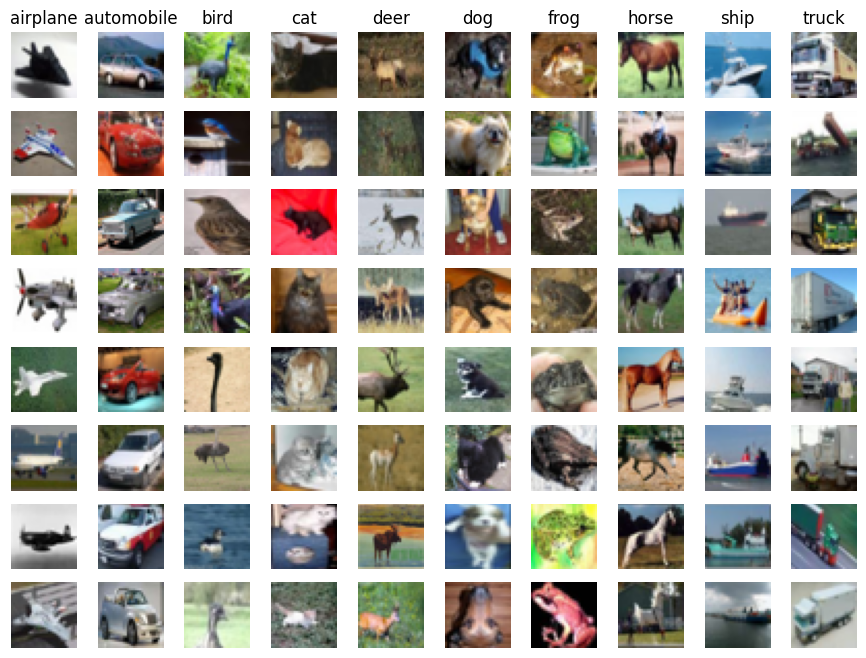

In [14]:
#The following code summarizes all previous operations.
#No Need to fill in this cell. You can continue the lab.

################## TODO BLOCK

def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    # Download / Load the datasets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Normalize the data
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255

    # Label vector
    labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
        'frog', 'horse', 'ship', 'truck'
    ]

    return x_train, y_train, x_test, y_test, labels

x_train, y_train, x_test, y_test, labels = load_cifar_data()

def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, 10, figsize=(11,8))

    for i in range(10):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)

#Reducing the size of the training set

#x_train = x_train[range(5000),:,:,:]
#y_train = y_train[range(5000)]

#x_test = x_train[range(500),:,:,:]
#y_test = y_train[range(500)]

################## END TODO BLOCK

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task. For the training, use the SGD optimizer with a learning rate of 0.1 and a decay of $10^{-6}$. The performance of the network will be assessed via the accuracy metric.**

In [15]:
################## TODO BLOCK

def dense_model(input_shape, num_classes):
    model = Sequential()
    #You need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(100, input_shape=(input_shape,), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))


    sgd = SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

################## END TODO BLOCK

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

################## TODO BLOCK

The inputs are of size
$$
32 \times 32 \times 3 = 3072.
$$

There are connections between each neuron of two consecutive layers, which correspond to a number of weights equal to
$$ 3072 \times 1024 + 1024 \times 512 + 512 \times 256 + 256 \times 100 + 100 \times 10
= 3827688 $$

The number of bias is equal to the number of intermediary neurons plus the number of neurons of the output layer:
$$ 1024 + 512 + 256 + 100 + 10 = 1902.$$

The total number of parameters is then $ 3827688 + 1902 = 3 829 590$.

################## END TODO BLOCK

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [16]:
################## TODO BLOCK

model = dense_model(x_train[0].shape, 10)
model.summary()

################## END TODO BLOCK

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 100)               25700     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 3829590 (14.61 MB)
Trainable params: 38295

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [17]:
################## TODO BLOCK


def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """

    stop_early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, mode='auto')

    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True,
                    callbacks=[stop_early], verbose = 2)

    if file_name:
        model.save(file_name)

    return ret

#Don't forget to initialize your model each time you train it, otherwise it will keep in memory the past
#parameter values: comparing the different trainings would not be fair in this case.
model = dense_model(x_train[0].shape, 10)
ret = train_model(model, x_train, y_train)

#You can use ret.history['val_loss'] or ret.history['val_accuracy'] to access the list of
#loss/accuracy for each epoch

#The retained model is the one minimizing the validation loss
best_model_accuracy = ret.history['val_accuracy'][np.argmin(ret.history['val_loss'])]
print("The accuracy of the final network is ", np.round(best_model_accuracy, decimals =3))
################## END TODO BLOCK

Epoch 1/10
1250/1250 - 7s - loss: 1.9384 - accuracy: 0.2896 - val_loss: 1.9315 - val_accuracy: 0.2898 - 7s/epoch - 6ms/step
Epoch 2/10
1250/1250 - 5s - loss: 1.7385 - accuracy: 0.3730 - val_loss: 1.7096 - val_accuracy: 0.3789 - 5s/epoch - 4ms/step
Epoch 3/10
1250/1250 - 5s - loss: 1.6499 - accuracy: 0.4058 - val_loss: 1.6785 - val_accuracy: 0.3957 - 5s/epoch - 4ms/step
Epoch 4/10
1250/1250 - 4s - loss: 1.5847 - accuracy: 0.4314 - val_loss: 1.6040 - val_accuracy: 0.4263 - 4s/epoch - 3ms/step
Epoch 5/10
1250/1250 - 5s - loss: 1.5348 - accuracy: 0.4457 - val_loss: 1.5665 - val_accuracy: 0.4440 - 5s/epoch - 4ms/step
Epoch 6/10
1250/1250 - 5s - loss: 1.4857 - accuracy: 0.4672 - val_loss: 1.5312 - val_accuracy: 0.4540 - 5s/epoch - 4ms/step
Epoch 7/10
1250/1250 - 4s - loss: 1.4442 - accuracy: 0.4823 - val_loss: 1.5064 - val_accuracy: 0.4643 - 4s/epoch - 3ms/step
Epoch 8/10
1250/1250 - 5s - loss: 1.4074 - accuracy: 0.4933 - val_loss: 1.5905 - val_accuracy: 0.4425 - 5s/epoch - 4ms/step
Epoch 9/

**11) Plot several images with their predictions. Any comment?**

313/313 [==============================] - 1s 2ms/step
The accuracy on the test set is 0.4712


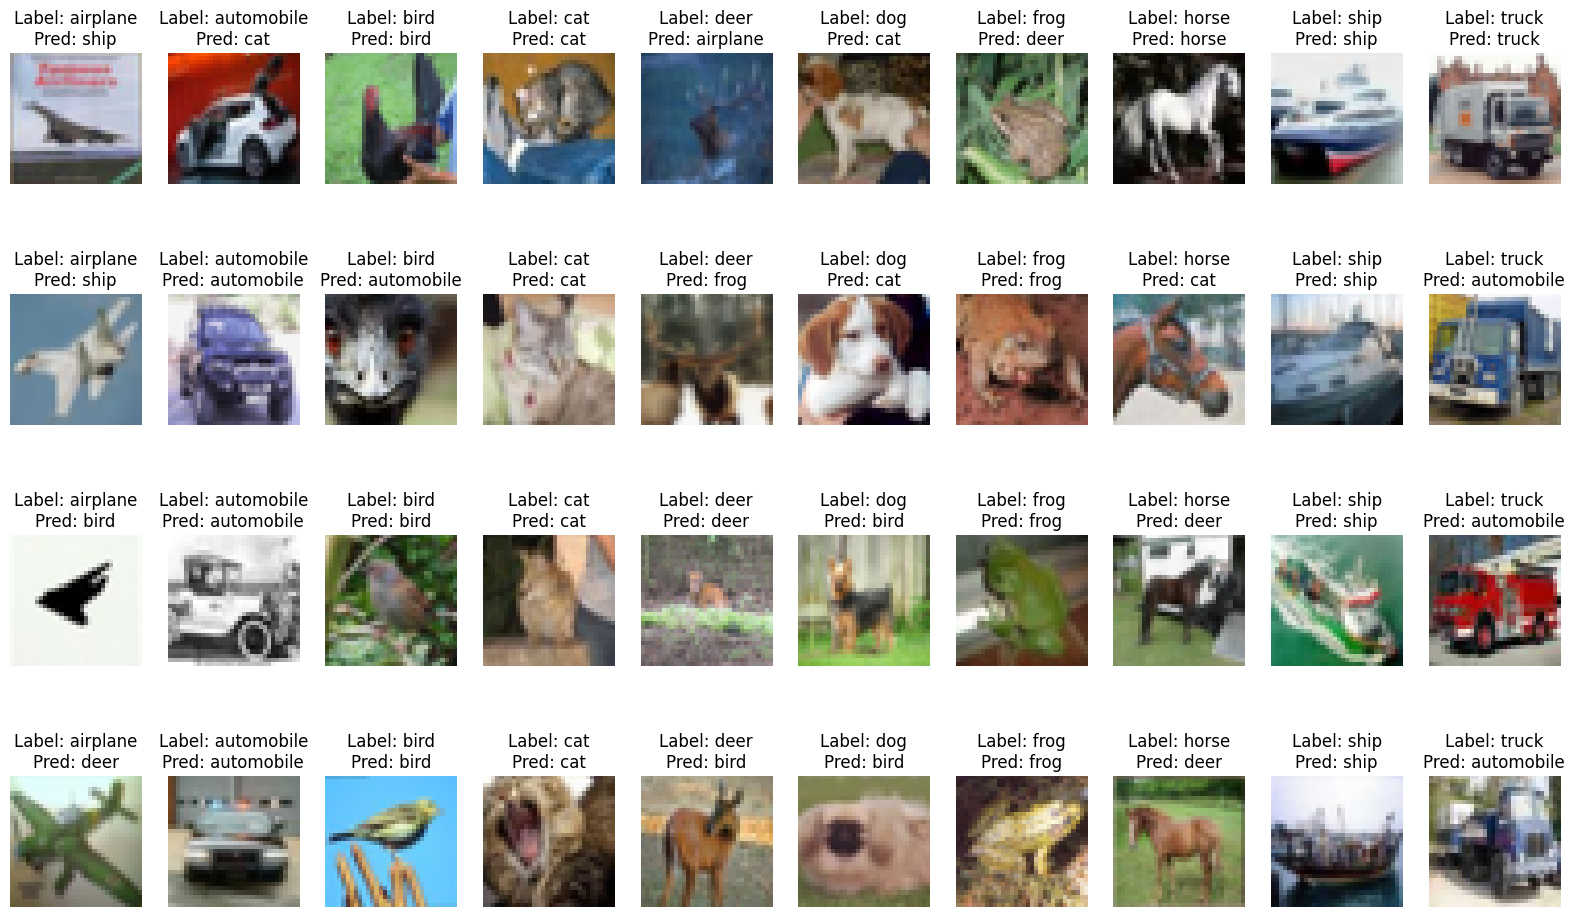

In [19]:
################## TODO BLOCK

#You can use ret.history['val_loss'] or ret.history['val_accuracy'] to access the list of
#loss/accuracy for each epoch

#Compute the predictions
predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)
#y_pred = model.predict_classes(x_test)
y_pred = to_categorical(classes_x, 10)

# Compute the accuracy
print("The accuracy on the test set is", metrics.accuracy_score(y_test, y_pred) )


f, ax = plt.subplots(4, 10, figsize=(20, 12))
for i in range(10):
    count, j = 0, 0
    while count < 4:
        if np.argmax(y_test[j]) == i:
            ax[count, i].imshow(x_test[j])
            ax[count, i].set_title("Label: " + labels[i] + '\n' + "Pred: " + labels[np.argmax(y_pred[j])])
            ax[count, i].axis('off')
            count += 1
        j +=1

# Some predictions are far from the true class. The algorithm is currently doing a poor job at identifying the
# image content. This was expected since we used neural networks that are not suited for dealing with images.
# Indeed, ANN/MLP do not use the spatial organization of the image to predict.

################## END TODO BLOCK

<a id='cnn'></a>

# 3 - Convolutional Neural Network


Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [28]:
################## TODO BLOCK

def cnn_model(input_shape, num_classes):
    model = Sequential()
    #padding = same allows you to keep the same size for the feature map if the stride is set to one
    # By default, there is no padding (=valid))
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(408))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create the model
model = cnn_model(x_train.shape[1:], 10)

################## END TODO BLOCK

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

################## TODO BLOCK

Number of parameters of the first convolutional layer:
$$
(3 \times 3 \times 3+1) \times 8 = 224
$$
Number of parameters of the second convolutional layer:
$$
(3 \times 3 \times 8+1) \times 8 = 584
$$
Number of parameters of the third convolutional layer:
$$
(3 \times 3 \times 8+1) \times 32 = 2336
$$
Number of parameters of the fourth convolutional layer:
$$
(3 \times 3 \times 32+1) \times 32 = 9248
$$
The flatten layer is composed of $6 \times 6 \times 32 = 1152$.
Between the flatten layer and the dense layer, there are
$$
1152 \times 408+408 = 470424
$$
connections. Between the dense layer and the output layer, there are
$$
408 \times 10+10 = 4090
$$
connections. All in all, the total number of parameters is
$$
224 + 584 + 2336 + 9248 + 470424 + 4090 = 486906
$$

################## END TODO BLOCK

In [29]:
################## TODO BLOCK

model.summary()

# There are less parameteres to train than in the ANN implemented above since CNN have less connections and some connections share the same parameter.
# Notice that the vast majority of parameters in CNN comes from the dense layer at the end of the network (it contains 470000 parameters, the whole network contains 487000).

################## END TODO BLOCK

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 activation_30 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 8)         584       
                                                                 
 activation_31 (Activation)  (None, 30, 30, 8)         0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 15, 15, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 15, 15, 32)        2336      
                                                      

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [30]:
################## TODO BLOCK

# Create the model
model = cnn_model(x_train.shape[1:], 10)

# Train the model
ret1 = train_model(model, x_train, y_train, batch_size= 32)

################## END TODO BLOCK

Epoch 1/10
1250/1250 - 8s - loss: 2.2735 - accuracy: 0.1265 - val_loss: 2.0862 - val_accuracy: 0.2274 - 8s/epoch - 6ms/step
Epoch 2/10
1250/1250 - 6s - loss: 1.6661 - accuracy: 0.3976 - val_loss: 1.5654 - val_accuracy: 0.4468 - 6s/epoch - 5ms/step
Epoch 3/10
1250/1250 - 6s - loss: 1.3357 - accuracy: 0.5245 - val_loss: 1.2443 - val_accuracy: 0.5562 - 6s/epoch - 5ms/step
Epoch 4/10
1250/1250 - 6s - loss: 1.1521 - accuracy: 0.5908 - val_loss: 1.1301 - val_accuracy: 0.6042 - 6s/epoch - 5ms/step
Epoch 5/10
1250/1250 - 6s - loss: 1.0053 - accuracy: 0.6439 - val_loss: 1.1585 - val_accuracy: 0.5977 - 6s/epoch - 5ms/step
Epoch 6/10
1250/1250 - 6s - loss: 0.8755 - accuracy: 0.6949 - val_loss: 1.1821 - val_accuracy: 0.5969 - 6s/epoch - 5ms/step


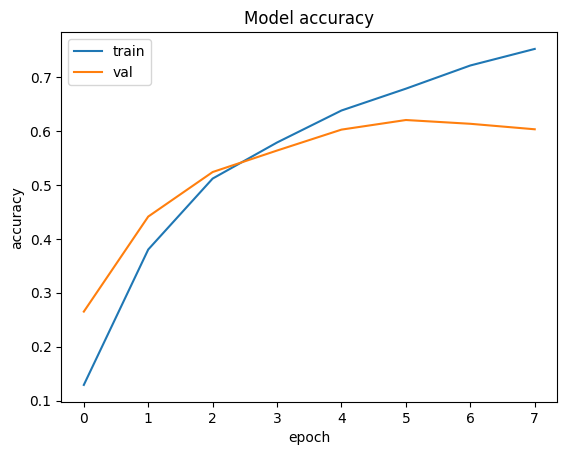

The accuracy of our first CNN is  0.62


In [24]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

plt.plot(ret1.history['accuracy'])
plt.plot(ret1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

best_model_accuracy = ret1.history['val_accuracy'][np.argmin(ret1.history['val_loss'])]
print("The accuracy of our first CNN is ", np.round(best_model_accuracy, decimals =3))

# We notice that the accuracy computed on the training set increases during the whole optimization.
# The accuracy computed on the validation set seems to reach a plateau after 3-4 epochs
# Note that early stopping makes the procedure stop at 8 epochs because epochs 6 and 7 have a lower validation accuracy than epoch 5.

################## END TODO BLOCK

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

In [25]:
################## TODO BLOCK

# Create and train the models
model = cnn_model(x_train.shape[1:], 10)
ret2 = train_model(model, x_train, y_train, batch_size=128)

# Create and train the models
model = cnn_model(x_train.shape[1:], 10)
ret3 = train_model(model, x_train, y_train, batch_size=512)

# Create and train the models
model = cnn_model(x_train.shape[1:], 10)
ret4 = train_model(model, x_train, y_train, batch_size=2048)

################## END TODO BLOCK

Epoch 1/10
313/313 - 4s - loss: 2.1726 - accuracy: 0.2105 - val_loss: 2.2661 - val_accuracy: 0.2169 - 4s/epoch - 13ms/step
Epoch 2/10
313/313 - 2s - loss: 1.7794 - accuracy: 0.3657 - val_loss: 1.9226 - val_accuracy: 0.3282 - 2s/epoch - 5ms/step
Epoch 3/10
313/313 - 2s - loss: 1.5156 - accuracy: 0.4576 - val_loss: 1.4099 - val_accuracy: 0.4942 - 2s/epoch - 6ms/step
Epoch 4/10
313/313 - 2s - loss: 1.3883 - accuracy: 0.5051 - val_loss: 1.3504 - val_accuracy: 0.5067 - 2s/epoch - 7ms/step
Epoch 5/10
313/313 - 2s - loss: 1.2545 - accuracy: 0.5549 - val_loss: 1.2973 - val_accuracy: 0.5409 - 2s/epoch - 6ms/step
Epoch 6/10
313/313 - 2s - loss: 1.1395 - accuracy: 0.5974 - val_loss: 1.2136 - val_accuracy: 0.5710 - 2s/epoch - 5ms/step
Epoch 7/10
313/313 - 2s - loss: 1.0476 - accuracy: 0.6327 - val_loss: 1.2211 - val_accuracy: 0.5733 - 2s/epoch - 5ms/step
Epoch 8/10
313/313 - 2s - loss: 0.9554 - accuracy: 0.6650 - val_loss: 1.1939 - val_accuracy: 0.5949 - 2s/epoch - 5ms/step
Epoch 9/10
313/313 - 2s

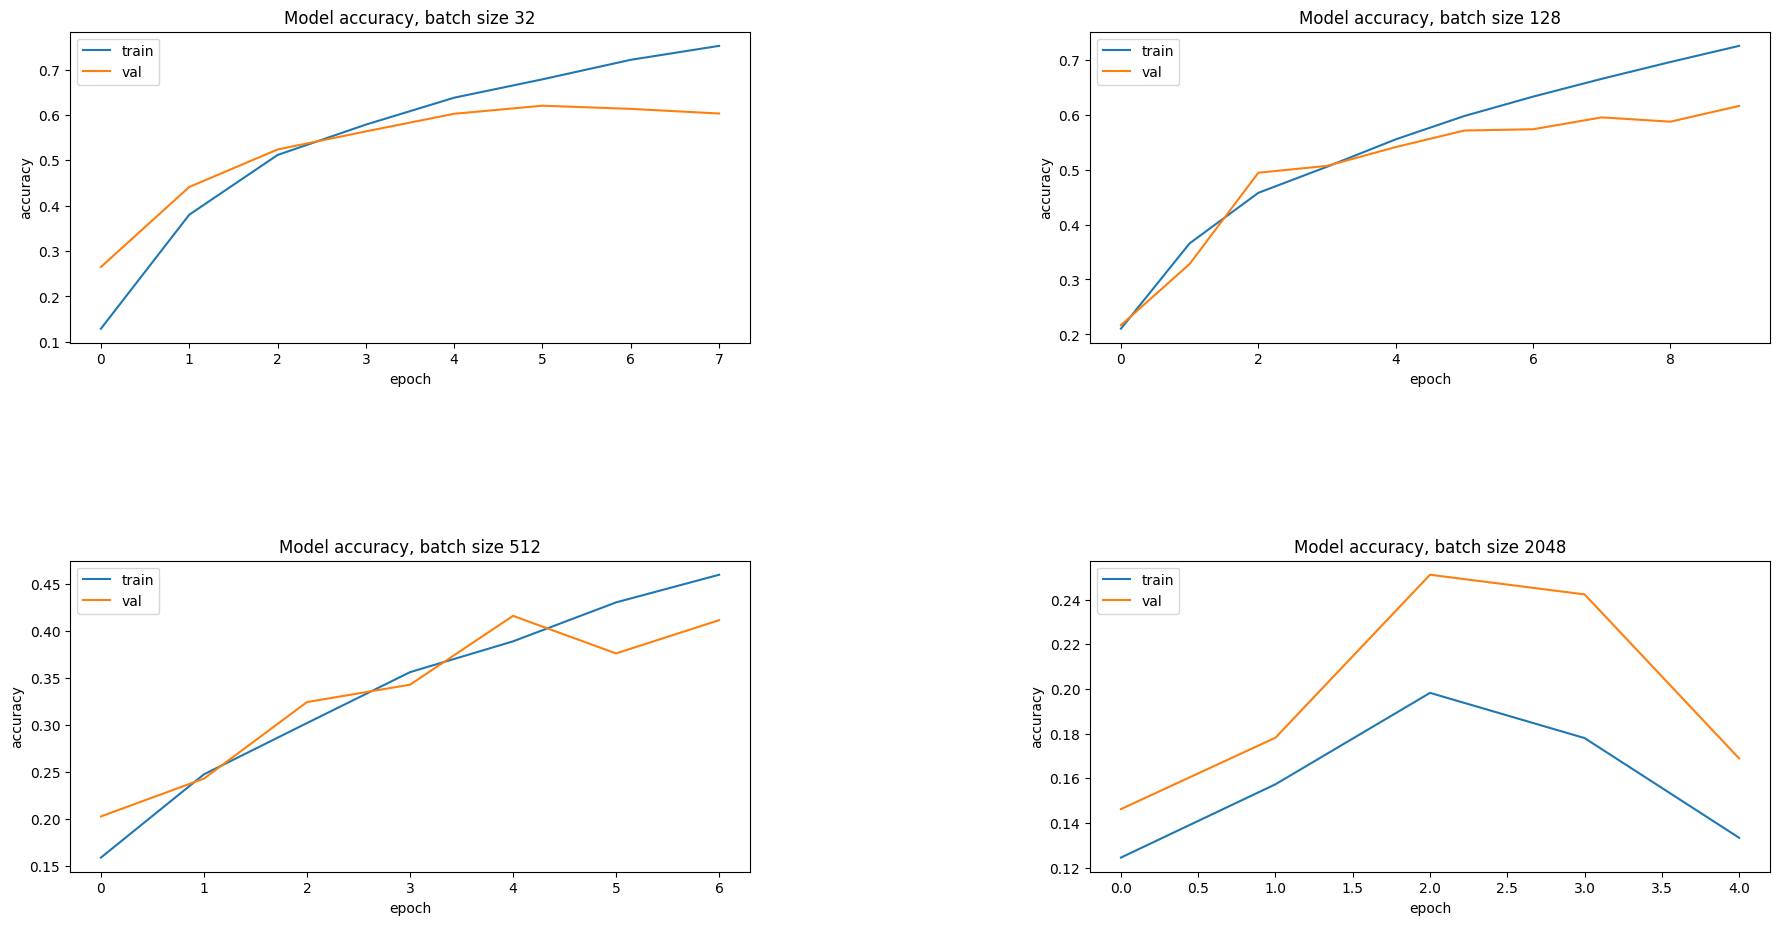

Text(0, 0.5, 'Validation accuracy')

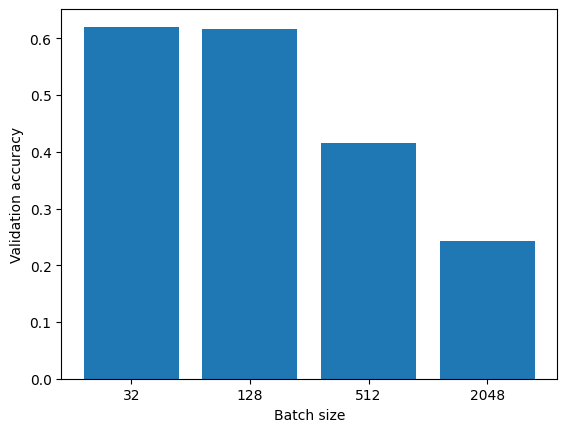

In [26]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# plot with various axes scales
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(ret1.history['accuracy'])
plt.plot(ret1.history['val_accuracy'])
plt.title('Model accuracy, batch size 32')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(222)
plt.plot(ret2.history['accuracy'])
plt.plot(ret2.history['val_accuracy'])
plt.title('Model accuracy, batch size 128')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(223)
plt.plot(ret3.history['accuracy'])
plt.plot(ret3.history['val_accuracy'])
plt.title('Model accuracy, batch size 512')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(224)
plt.plot(ret4.history['accuracy'])
plt.plot(ret4.history['val_accuracy'])
plt.title('Model accuracy, batch size 2048')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.7,
                    wspace=0.5)

plt.show()

#Final model accuracy
val_accuracy_models = [ret1.history['val_accuracy'][np.argmin(ret1.history['val_loss'])], ret2.history['val_accuracy'][np.argmin(ret2.history['val_loss'])],
                       ret3.history['val_accuracy'][np.argmin(ret3.history['val_loss'])], ret4.history['val_accuracy'][np.argmin(ret4.history['val_loss'])]]
plt.bar(x = [1,2,3,4], height = val_accuracy_models,
        tick_label = ["32", "128", "512", "2048"])

# Add title and axis names
plt.xlabel('Batch size')
plt.ylabel('Validation accuracy')

# Notice how the performance of the final model decreases as the size of the batch increases. In theory, we
# would prefer to have a batch size of one. This trend is exemplified with these plots.
# However, you may also notice that the training time is larger when the size of the batch decreases.
# Therefore a tradeoff between accuracy and training time must be found.

################## END TODO BLOCK

**16) Consider now a batch size of 32 and consider the above CNN. Try adding 3 dropout layers to this model, one after each max-pooling layer and one before the last layer, using a dropout of parameter p=0.25. Does this improve the model? How does the performance vary with the dropout ratio? What does p correspond to?**

In [ ]:
################## TODO BLOCK


def cnn_model(input_shape, num_classes, p=0.25):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(p))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(p))

    model.add(Flatten())
    model.add(Dense(408))
    model.add(Activation('relu'))
    model.add(Dropout(p))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(learning_rate=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create and train the model with p=0.1
model = cnn_model(x_train.shape[1:], 10, p=0.1)
ret1 = train_model(model, x_train, y_train, batch_size=32)

# Create and train the model with p=0.25
model = cnn_model(x_train.shape[1:], 10, p=0.25)
ret2 = train_model(model, x_train, y_train, batch_size=32)

# Create and train the model with p=0.5
model = cnn_model(x_train.shape[1:], 10, p=0.5)
ret3 = train_model(model, x_train, y_train, batch_size=32)

# Create and train the model with p=0.9
model = cnn_model(x_train.shape[1:], 10, p=0.9)
ret4 = train_model(model, x_train, y_train, batch_size=32)

################## END TODO BLOCK

Epoch 1/10
1250/1250 - 7s - loss: 2.2866 - accuracy: 0.1197 - val_loss: 2.1275 - val_accuracy: 0.2665 - 7s/epoch - 6ms/step
Epoch 2/10
1250/1250 - 6s - loss: 1.9437 - accuracy: 0.2912 - val_loss: 1.6819 - val_accuracy: 0.3916 - 6s/epoch - 5ms/step
Epoch 3/10
1250/1250 - 6s - loss: 1.5789 - accuracy: 0.4320 - val_loss: 1.4136 - val_accuracy: 0.4978 - 6s/epoch - 5ms/step
Epoch 4/10
1250/1250 - 6s - loss: 1.4013 - accuracy: 0.5013 - val_loss: 1.2653 - val_accuracy: 0.5602 - 6s/epoch - 5ms/step
Epoch 5/10
1250/1250 - 6s - loss: 1.2810 - accuracy: 0.5445 - val_loss: 1.2180 - val_accuracy: 0.5596 - 6s/epoch - 5ms/step
Epoch 6/10
1250/1250 - 6s - loss: 1.1895 - accuracy: 0.5802 - val_loss: 1.2393 - val_accuracy: 0.5651 - 6s/epoch - 5ms/step
Epoch 7/10
1250/1250 - 6s - loss: 1.1019 - accuracy: 0.6120 - val_loss: 1.1168 - val_accuracy: 0.6138 - 6s/epoch - 5ms/step
Epoch 8/10
1250/1250 - 6s - loss: 1.0340 - accuracy: 0.6364 - val_loss: 1.2265 - val_accuracy: 0.5826 - 6s/epoch - 5ms/step
Epoch 9/

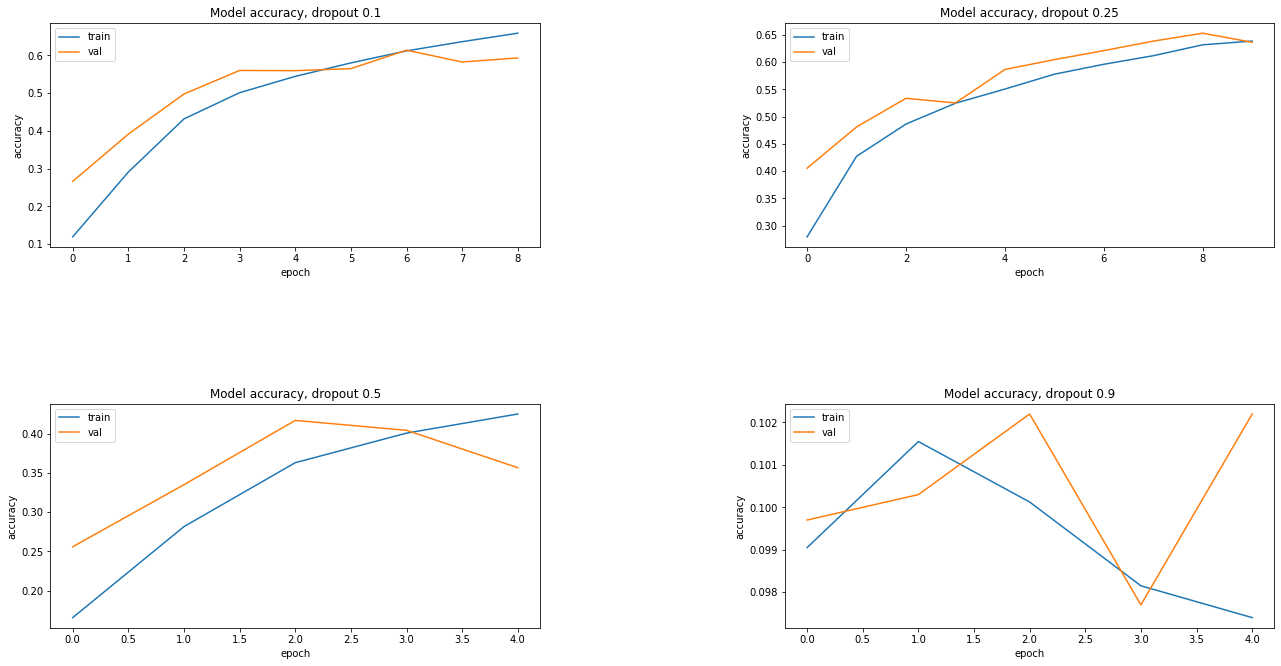

Text(0, 0.5, 'Validation accuracy')

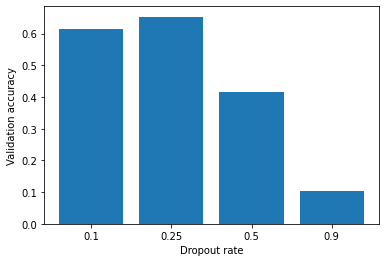

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# plot with various axes scales
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(ret1.history['accuracy'])
plt.plot(ret1.history['val_accuracy'])
plt.title('Model accuracy, dropout 0.1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(222)
plt.plot(ret2.history['accuracy'])
plt.plot(ret2.history['val_accuracy'])
plt.title('Model accuracy, dropout 0.25')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(223)
plt.plot(ret3.history['accuracy'])
plt.plot(ret3.history['val_accuracy'])
plt.title('Model accuracy, dropout 0.5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(224)
plt.plot(ret4.history['accuracy'])
plt.plot(ret4.history['val_accuracy'])
plt.title('Model accuracy, dropout 0.9')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.7,
                    wspace=0.5)

plt.show()

#Final model accuracy

val_accuracy_models = [ret1.history['val_accuracy'][np.argmin(ret1.history['val_loss'])], ret2.history['val_accuracy'][np.argmin(ret2.history['val_loss'])],
                       ret3.history['val_accuracy'][np.argmin(ret3.history['val_loss'])], ret4.history['val_accuracy'][np.argmin(ret4.history['val_loss'])]]
plt.bar(x = [1,2,3,4], height = val_accuracy_models,
        tick_label = ["0.1", "0.25", "0.5", "0.9"])

# Add title and axis names
plt.xlabel('Dropout rate')
plt.ylabel('Validation accuracy')

# The dropout layers do not improve the model performance. The best performance is obtained for p=0.1,
# which corresponds to a probability of removing neurons equal to 0.5.
# However the performance is the same in terms of validation accuracy as that of the network that does not
# contain dropout layers
# Since dropout is used to regularize the network, it may occur here since the network is not complex enough and
# does not need any regularization.
# Indeed, the best value for p is p=0, which corresponds to no dropout layer (all neurons are kept during the
# training).
# Increasing the size of the network could lead to more efficient dropout layers.
# Note that tuning the dropout parameter is crucial in this case. The performance of the last network is 0.10 in
# terms of validation accuracy (which corresponds to random prediction)

################## END TODO BLOCK

**17) Add batch normalization layers before each dropout layer, with the dropout parameter of your choice. What is the impact of batch normalization on the model's performance?**

In [ ]:
################## TODO BLOCK
p=0.1

def cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(p))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(p))

    model.add(Flatten())
    model.add(Dense(408))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(p))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(learning_rate=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create and train the model with p=0.1
model = cnn_model(x_train.shape[1:], 10)
ret = train_model(model, x_train, y_train, batch_size=32)

################## END TODO BLOCK

Epoch 1/10
1250/1250 - 8s - loss: 1.7605 - accuracy: 0.4091 - val_loss: 1.8917 - val_accuracy: 0.3976 - 8s/epoch - 7ms/step
Epoch 2/10
1250/1250 - 6s - loss: 1.3469 - accuracy: 0.5305 - val_loss: 1.3107 - val_accuracy: 0.5644 - 6s/epoch - 5ms/step
Epoch 3/10
1250/1250 - 7s - loss: 1.1644 - accuracy: 0.5944 - val_loss: 1.2352 - val_accuracy: 0.5745 - 7s/epoch - 5ms/step
Epoch 4/10
1250/1250 - 7s - loss: 1.0297 - accuracy: 0.6384 - val_loss: 1.0446 - val_accuracy: 0.6381 - 7s/epoch - 5ms/step
Epoch 5/10
1250/1250 - 6s - loss: 0.9265 - accuracy: 0.6748 - val_loss: 1.2831 - val_accuracy: 0.5764 - 6s/epoch - 5ms/step
Epoch 6/10
1250/1250 - 7s - loss: 0.8552 - accuracy: 0.7000 - val_loss: 0.9304 - val_accuracy: 0.6860 - 7s/epoch - 5ms/step
Epoch 7/10
1250/1250 - 6s - loss: 0.7933 - accuracy: 0.7218 - val_loss: 0.9317 - val_accuracy: 0.6860 - 6s/epoch - 5ms/step
Epoch 8/10
1250/1250 - 6s - loss: 0.7426 - accuracy: 0.7371 - val_loss: 1.1942 - val_accuracy: 0.6219 - 6s/epoch - 5ms/step


The accuracy of the CNN with batch normalization is  0.686


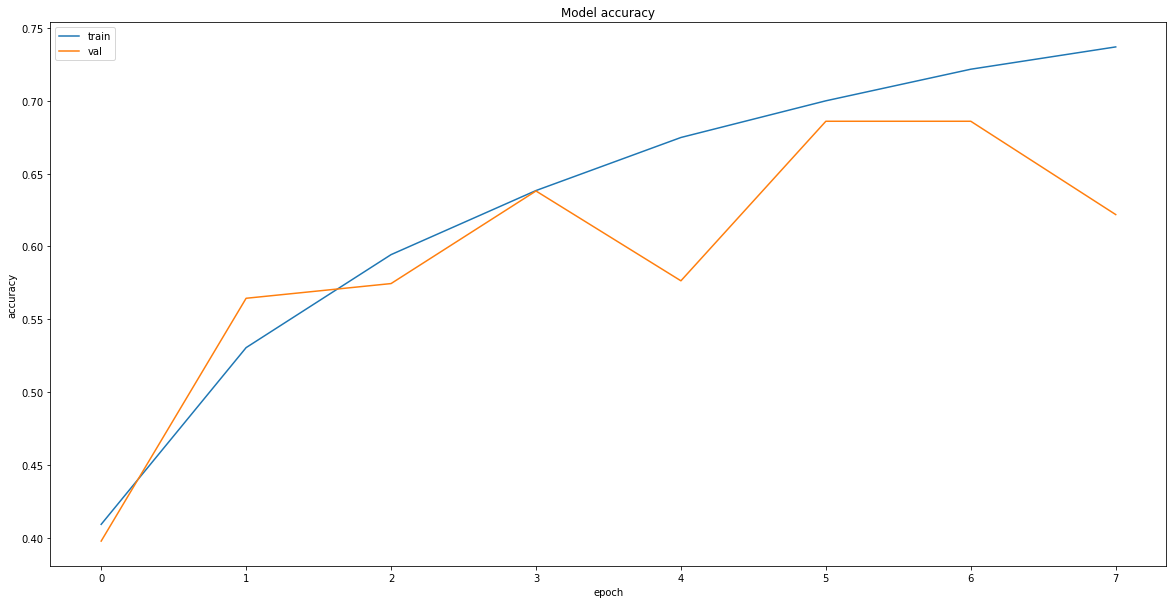

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

best_model_accuracy = ret.history['val_accuracy'][np.argmin(ret.history['val_loss'])]
print("The accuracy of the CNN with batch normalization is ", np.round(best_model_accuracy, decimals =3))

plt.figure(figsize=(20,10))

plt.plot(ret.history['accuracy'])
plt.plot(ret.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Applying batch normalization here improves a lot the network performance,
# achieving a validation accuracy of 0.6775. Our cnn baseline (the first trained cnn) reaches a
# validation accuracy of 0.62.

################## END TODO BLOCK

**18) Based on the CNNs you have considered so far in this lab, what would be the next improvement you would like to test to increase the validation accuracy of your model? Test it and comment.**

In [ ]:
################## TODO BLOCK

# We can first add Early Stopping.
# Early stopping is a method that allows you to specify an arbitrary large number of training epochs and
# stop training once the model performance stops improving on a hold out validation dataset.
#
# Next, since batch normalization was useful and dropout was not when used alone,
# we could try to train the last CNN without any dropout layer.
# The performance is better than that of the first CNN.

def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """

    stop_early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, mode='auto')

    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True,
                    callbacks=[stop_early], verbose = 2)

    if file_name:
        model.save(file_name)

    return ret

def cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(408))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(learning_rate=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create and train the model
model = cnn_model(x_train.shape[1:], 10)
ret = train_model(model, x_train, y_train, batch_size=32)

################## END TODO BLOCK

Epoch 1/10
1250/1250 - 8s - loss: 1.6643 - accuracy: 0.4375 - val_loss: 1.4941 - val_accuracy: 0.4992 - 8s/epoch - 6ms/step
Epoch 2/10
1250/1250 - 7s - loss: 1.2192 - accuracy: 0.5758 - val_loss: 1.2230 - val_accuracy: 0.5801 - 7s/epoch - 5ms/step
Epoch 3/10
1250/1250 - 7s - loss: 1.0111 - accuracy: 0.6448 - val_loss: 1.1758 - val_accuracy: 0.5869 - 7s/epoch - 5ms/step
Epoch 4/10
1250/1250 - 7s - loss: 0.8587 - accuracy: 0.6988 - val_loss: 1.2835 - val_accuracy: 0.5931 - 7s/epoch - 5ms/step
Epoch 5/10
1250/1250 - 6s - loss: 0.7364 - accuracy: 0.7417 - val_loss: 1.0938 - val_accuracy: 0.6488 - 6s/epoch - 5ms/step
Epoch 6/10
1250/1250 - 7s - loss: 0.6275 - accuracy: 0.7796 - val_loss: 1.1139 - val_accuracy: 0.6479 - 7s/epoch - 5ms/step
Epoch 7/10
1250/1250 - 6s - loss: 0.5348 - accuracy: 0.8132 - val_loss: 1.2137 - val_accuracy: 0.6350 - 6s/epoch - 5ms/step


The accuracy of the CNN is now  0.649


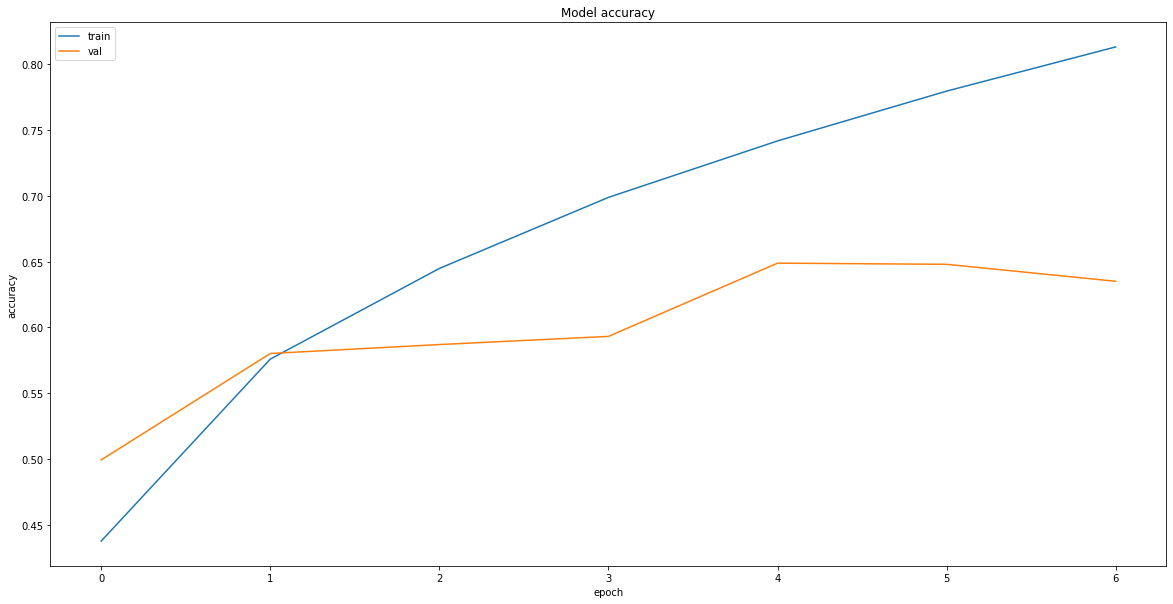

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

best_model_accuracy = ret.history['val_accuracy'][np.argmin(ret.history['val_loss'])]
print("The accuracy of the CNN is now ", np.round(best_model_accuracy, decimals =3))

plt.figure(figsize=(20,10))

plt.plot(ret.history['accuracy'])
plt.plot(ret.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# The CNN with batch_size = 32, three layers of batch normalization and no dropout reaches a
# validation accuracy of 0.6611

################## END TODO BLOCK

In [ ]:
################## TODO BLOCK

# Secondly, we could look for the best optimizer.
# We test four optimizers : SGD, RMSProp, Adam, Nadam.
# RMSProp is adapting the learning rate at each iteration.
# Adam is essentially RMSprop with momentum, Nadam is Adam with Nesterov momentum.

from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam

def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """

    stop_early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=4, mode='auto')

    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True,
                    callbacks=[stop_early], verbose = 2)

    if file_name:
        model.save(file_name)

    return ret

def cnn_model(input_shape, num_classes, optimizer):
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(8,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(408))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Note that for RMSprop, Adam and Nadam, we take much lower initial learning rate.
optimizers = [SGD(learning_rate=0.1, decay=1.0e-6),
              RMSprop(learning_rate=0.001),
              Adam(learning_rate=0.001),
              Nadam(learning_rate=0.001)]

# Create and train the model
model_sgd = cnn_model(x_train.shape[1:], 10, optimizers[0])
ret_sgd = train_model(model_sgd, x_train, y_train, batch_size=32)

model_rmsprop = cnn_model(x_train.shape[1:], 10, optimizers[1])
ret_rmsprop = train_model(model_rmsprop, x_train, y_train, batch_size=32)

model_adam = cnn_model(x_train.shape[1:], 10, optimizers[2])
ret_adam = train_model(model_adam, x_train, y_train, batch_size=32)

model_nadam = cnn_model(x_train.shape[1:], 10, optimizers[3])
ret_nadam = train_model(model_nadam, x_train, y_train, batch_size=32)

################## END TODO BLOCK

Epoch 1/10
1250/1250 - 8s - loss: 1.6460 - accuracy: 0.4464 - val_loss: 1.5145 - val_accuracy: 0.5038 - 8s/epoch - 6ms/step
Epoch 2/10
1250/1250 - 7s - loss: 1.2042 - accuracy: 0.5818 - val_loss: 1.1982 - val_accuracy: 0.5866 - 7s/epoch - 5ms/step
Epoch 3/10
1250/1250 - 7s - loss: 0.9881 - accuracy: 0.6544 - val_loss: 1.2848 - val_accuracy: 0.5981 - 7s/epoch - 5ms/step
Epoch 4/10
1250/1250 - 7s - loss: 0.8473 - accuracy: 0.7050 - val_loss: 1.2428 - val_accuracy: 0.6229 - 7s/epoch - 5ms/step
Epoch 5/10
1250/1250 - 6s - loss: 0.7079 - accuracy: 0.7491 - val_loss: 1.1457 - val_accuracy: 0.6326 - 6s/epoch - 5ms/step
Epoch 6/10
1250/1250 - 7s - loss: 0.6016 - accuracy: 0.7877 - val_loss: 1.1175 - val_accuracy: 0.6663 - 7s/epoch - 5ms/step
Epoch 7/10
1250/1250 - 7s - loss: 0.4968 - accuracy: 0.8245 - val_loss: 1.3148 - val_accuracy: 0.6531 - 7s/epoch - 5ms/step
Epoch 8/10
1250/1250 - 7s - loss: 0.4073 - accuracy: 0.8573 - val_loss: 1.3269 - val_accuracy: 0.6453 - 7s/epoch - 5ms/step
Epoch 9/

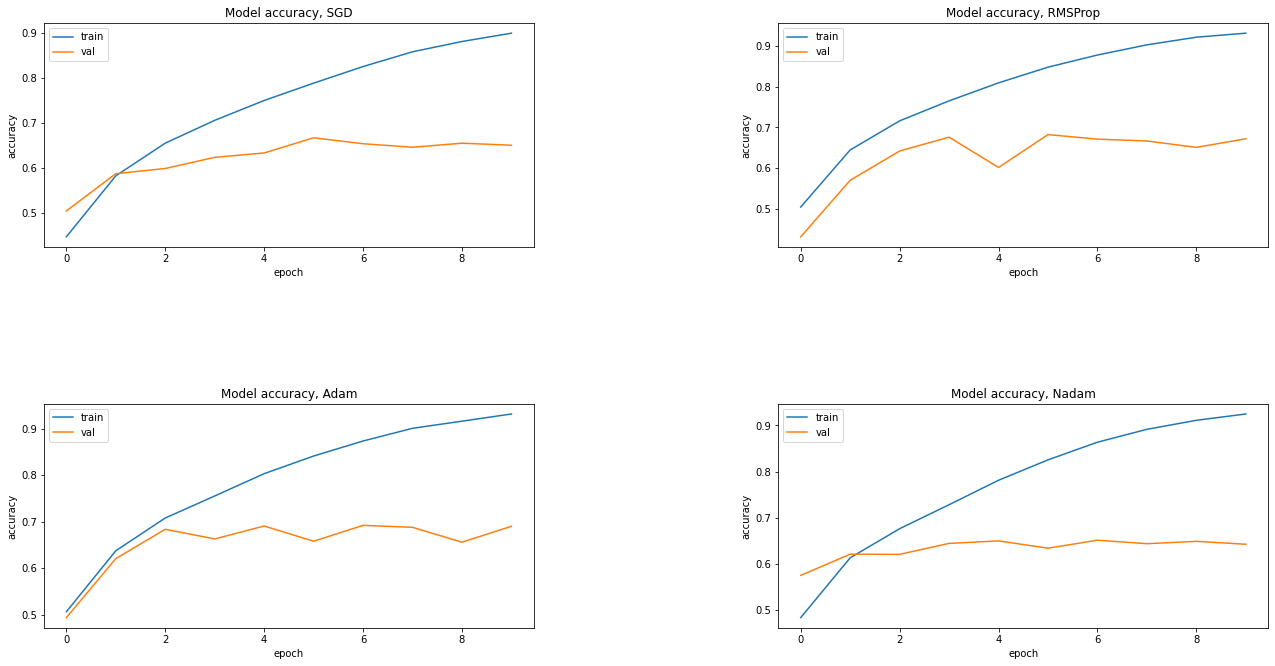

Text(0, 0.5, 'Validation accuracy')

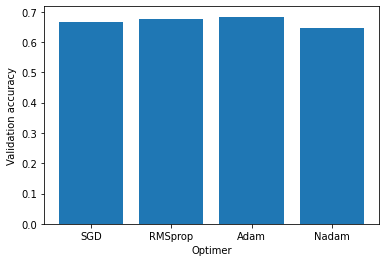

In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# plot with various axes scales
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.plot(ret_sgd.history['accuracy'])
plt.plot(ret_sgd.history['val_accuracy'])
plt.title('Model accuracy, SGD')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(222)
plt.plot(ret_rmsprop.history['accuracy'])
plt.plot(ret_rmsprop.history['val_accuracy'])
plt.title('Model accuracy, RMSProp')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(223)
plt.plot(ret_adam.history['accuracy'])
plt.plot(ret_adam.history['val_accuracy'])
plt.title('Model accuracy, Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(224)
plt.plot(ret_nadam.history['accuracy'])
plt.plot(ret_nadam.history['val_accuracy'])
plt.title('Model accuracy, Nadam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.7,
                    wspace=0.5)

plt.show()

#Final model accuracy

val_accuracy_models = [ret_sgd.history['val_accuracy'][np.argmin(ret_sgd.history['val_loss'])],
                       ret_rmsprop.history['val_accuracy'][np.argmin(ret_rmsprop.history['val_loss'])],
                       ret_adam.history['val_accuracy'][np.argmin(ret_adam.history['val_loss'])],
                       ret_nadam.history['val_accuracy'][np.argmin(ret_nadam.history['val_loss'])]]
plt.bar(x = [1,2,3,4], height = val_accuracy_models,
        tick_label = ["SGD", "RMSprop", "Adam", "Nadam"])

# Add title and axis names
plt.xlabel('Optimer')
plt.ylabel('Validation accuracy')

# The four optimizers seem to be equivalent on this example. But in practice, Adam is widely used.

################## END TODO BLOCK

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**19) Use `predict` on your trained model (the best you have created so far) to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for few test images. Compute the accuracy of your model on the test set and comment.**

NB: You can save the model after training it (function `save` in keras), and then decide to load from saved file instead of building a new one (if available) on successive runs (via the function `load_model` in keras).**

313/313 [==============================] - 1s 4ms/step
The accuracy on the test set is 0.5994


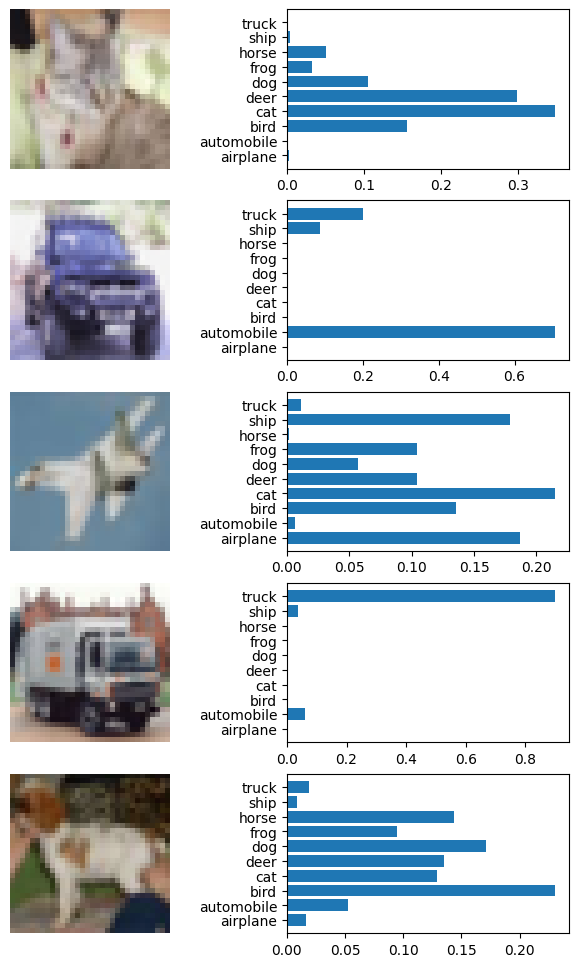

In [33]:
################## TODO BLOCK

def predict(model, x, labels, file_name=None):
    y = model.predict(x)

    f, ax = plt.subplots(x.shape[0], 2, figsize=(8,12))
    y_pos = np.arange(10)

    for i in range(x.shape[0]):
        ax[i,0].imshow(x[i,:,:,:])
        ax[i,0].axis('off')
        ax[i,1].barh(y_pos, y[i,:],align='center')
        ax[i,1].set_yticks(y_pos)
        ax[i,1].set_yticklabels(labels)

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

predict(model, x_test[8:13,:,:,:], labels, file_name="predictions.png")

#Compute the predictions
predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)
#y_pred = model.predict_classes(x_test)
y_pred = to_categorical(classes_x, 10)

# The accuracy on the test set is lower than that computed on the validation set. It was expected since the validation set was seen during the training. The validation error is thus likely to be optimistic.
# We see that the results are better than that of regular neural networks (around 0.47, see the beginning of the lab). We have used the spatial structure of images to predict and the performance are better!
################## END TODO BLOCK

# Compute the accuracy
print("The accuracy on the test set is", metrics.accuracy_score(y_test, y_pred) )

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.

**20) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

313/313 [==============================] - 1s 2ms/step


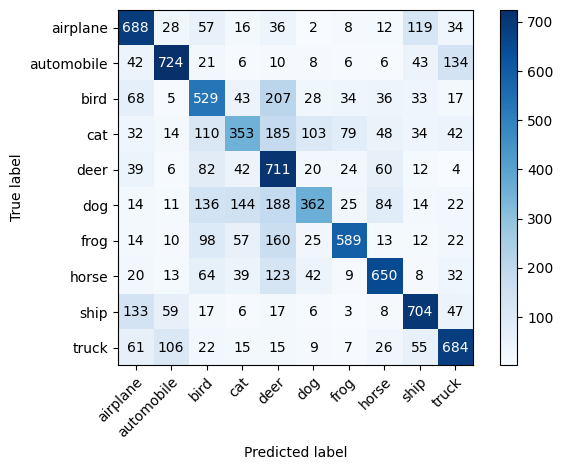

In [34]:
################## TODO BLOCK

import sklearn.metrics as metrics

y_pred_one = model.predict(x_test)  # shape=(n_samples, 12)
y_pred = np.argmax(y_pred_one, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
y_true = np.argmax(y_test, axis=1)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = ''

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=False,
                      title='')

plt.show()

# You notice that most obervations are correctly classified (in the diagonal).
# The confusion matrix allows us to see if predictions errors are somehow understandable. We look at the large
# numbers.
# We see for example that predicted trucks may turn out to be automobile or predicted horses may be deers.
# These erros seem quite consistent, especially given the pixel quality of the available images.

################## END TODO BLOCK

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**21) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.**

In [ ]:
# Import all usefull libraries

################## TODO BLOCK

# A tutorial can be found here : https://www.tensorflow.org/tutorials/images/transfer_learning

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import utils
from keras.utils import np_utils

import numpy as np
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
from sklearn import metrics

# Exactly like before, we load and pre-process the data for the training.
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)


labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

################## END TODO BLOCK

In [ ]:
################## TODO BLOCK

# we will use transfer learning to improve the accuracy of our model. To do so, we will take advantage of
# pretrained model and "transfer" their knowledge to our usecase. On top of the already pretrained layers,
# we will add Dense network that will map the pretrained features to our labels.
#
# We must split the training into two stages:
# 1. Training only the last additional layers. (layer.trainable=False)
# 2. Training the full network. (layer.trainable=True)
#
# The reason why we do that is because in the early stages of training your additional layers don't know
# what to do. The gradient is very noisy. If we apply this noisy gradient to the first already trained
# layer, we are going to move them away from the optimal points.
# After some iterations that has tuned the last layers that have been randomly initialized, we can
# unfreeze the first layers. But because we already in a close neighborhood  of an optimal points,
# we need to use a very small step size. Otherwise, we will be quickly thrown out from this
# neighborhood.
#
# It is very common in transfer learning to completely freeze the transferred layers in order to preserve them
# during the first iterations.
#
# For more details, see: https://stackoverflow.com/a/61294337

# Get back the convolutional part of a VGG network trained on ImageNet
# The include_top = False portion means that the last portion of the VGG19 classifier which are three dense
# layers are left out.
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32,32, 3))

# Add the fully-connected layers
x = Flatten(name='flatten')(vgg16.output)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
outputs = Dense(10, activation='softmax', name='predictions')(x)

#Create your own model
final_model = Model(inputs=vgg16.input, outputs=outputs)

# Setting layers.trainable to false leads to freeze the current model (which mostly consists of convolutional
# layers).
for layer in vgg16.layers: layer.trainable=False

final_model.summary()

opt = SGD(lr=0.01, momentum=0.9)
final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

final_model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

# keep track of the training and the validation accuracy in the first training stage
history_train = final_model.history.history['accuracy']
history_val = final_model.history.history['val_accuracy']

# New second stage: unfreeze and continue training.
for layer in final_model.layers: layer.trainable = True

# For the second round of optimization, we use an optimizer with a step size 10x smaller.
opt = Adam(lr=0.0001)
final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

final_model.fit(x_train, y_train, epochs=10, batch_size=256, validation_split=0.2)

# Add the training and validation accuracy of the second stage training
history_train.extend(final_model.history.history['accuracy'])
history_val.extend(final_model.history.history['val_accuracy'])

################## END TODO BLOCK

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
157/157 [==============================] - 9s 56ms/step - loss: 1.6767 - accuracy: 0.4113 - val_loss: 1.4405 - val_accuracy: 0.4906
Epoch 2/10
157/157 [==============================] - 8s 53ms/step - loss: 1.3823 - accuracy: 0.5174 - val_loss: 1.4300 - val_accuracy: 0.4922
Epoch 3/10
157/157 [==============================] - 8s 54ms/step - loss: 1.2971 - accuracy: 0.5458 - val_loss: 1.2680 - val_accuracy: 0.5547
Epoch 4/10
157/157 [==============================] - 9s 59ms/step - loss: 1.2393 - accuracy: 0.5685 - val_loss: 1.2361 - val_accuracy: 0.5678
Epoch 5/10
157/157 [==============================] - 9s 56ms/step - loss: 1.2191 - accuracy: 0.5745 - val_loss: 1.2612 - val_accuracy: 0.5544
Epoch 6/10
157/157 [==============================] - 8s 48ms/step - loss: 1.1890 - accuracy: 0.5837 - val_loss: 1.2212 - val_accuracy: 0.5661
Epoch 7/10
157/157 [==============================] - 8s 49ms/step - loss: 1.1636 - accuracy: 0.5907 - val_loss: 1.2021 - val_accuracy: 0.5752

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
157/157 [==============================] - 23s 138ms/step - loss: 1.0625 - accuracy: 0.6392 - val_loss: 0.7286 - val_accuracy: 0.7410
Epoch 2/10
157/157 [==============================] - 20s 126ms/step - loss: 0.5895 - accuracy: 0.7952 - val_loss: 0.5761 - val_accuracy: 0.7992
Epoch 3/10
157/157 [==============================] - 21s 131ms/step - loss: 0.4433 - accuracy: 0.8439 - val_loss: 0.5364 - val_accuracy: 0.8111
Epoch 4/10
157/157 [==============================] - 21s 134ms/step - loss: 0.3298 - accuracy: 0.8849 - val_loss: 0.5471 - val_accuracy: 0.8209
Epoch 5/10
157/157 [==============================] - 19s 122ms/step - loss: 0.2495 - accuracy: 0.9111 - val_loss: 0.5041 - val_accuracy: 0.8287
Epoch 6/10
157/157 [==============================] - 22s 139ms/step - loss: 0.1712 - accuracy: 0.9403 - val_loss: 0.6207 - val_accuracy: 0.8172
Epoch 7/10
157/157 [==============================] - 22s 140ms/step - loss: 0.1193 - accuracy: 0.9577 - val_loss: 0.6177 - val_ac

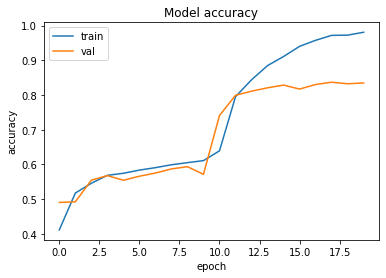

The accuracy of our final network trained with VGG16 is  0.829


In [ ]:
# Plot the evolution of (train/val) accuracy through epochs

################## TODO BLOCK

import matplotlib.pyplot as plt

plt.plot(history_train)
plt.plot(history_val)
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

best_model_accuracy = final_model.history.history['val_accuracy'][np.argmin(final_model.history.history['val_loss'])]
print("The accuracy of our final network trained with VGG16 is ", np.round(best_model_accuracy, decimals =3))

# We can observe the two stage of the training. First, while we train only the last layers of our model, we quickly
# reach a saturation. But as soon as we unfreeze the whole layer, we have a fast enhancement of the accuray,
# before saturating again but this time, at a much higher level.

################## END TODO BLOCK

313/313 [==============================] - 7s 21ms/step - loss: 0.7944 - accuracy: 0.8257
Test accuracy: 0.8256999850273132
Number of labels: [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
Number of prediction by labels: [1040.41 1063.63  852.53 1348.88 1082.24  719.05 1133.35  884.54  922.31
  952.98]
Ratio prediction/truth:  [1.04 1.06 0.85 1.35 1.08 0.72 1.13 0.88 0.92 0.95]


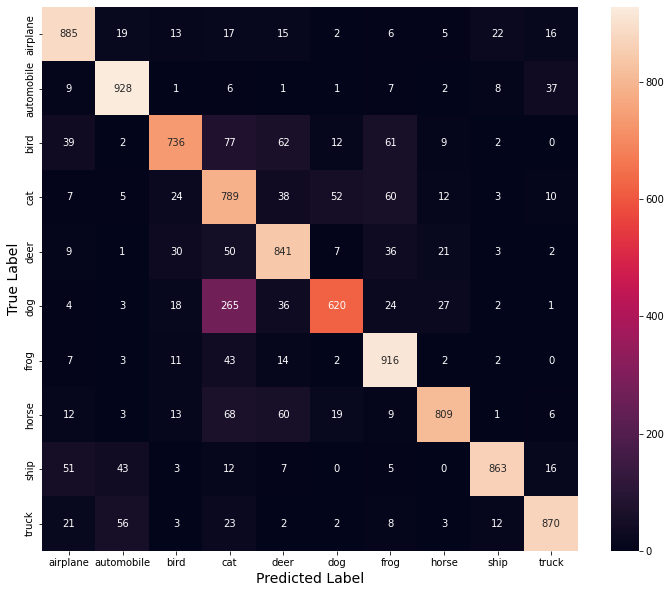

In [ ]:
################## TODO BLOCK

_, acc = final_model.evaluate(x_test, y_test)
print('Test accuracy:', acc)

y_pred = final_model.predict(x_test)

# Here is the distribution of predictions : if an element is close to one,
# the algorithm almost always predict the correct category
print("Number of labels:", y_test.sum(axis=0))
print("Number of prediction by labels:", y_pred.sum(axis=0))
print("Ratio prediction/truth: ", y_pred.sum(axis=0)/y_test.sum(axis=0))

# We plot the confusion matrix.
plt.figure(figsize=(12, 10))
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.heatmap(matrix, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

################## END TODO BLOCK

**22) Plot several images with their predictions. Any comment?**

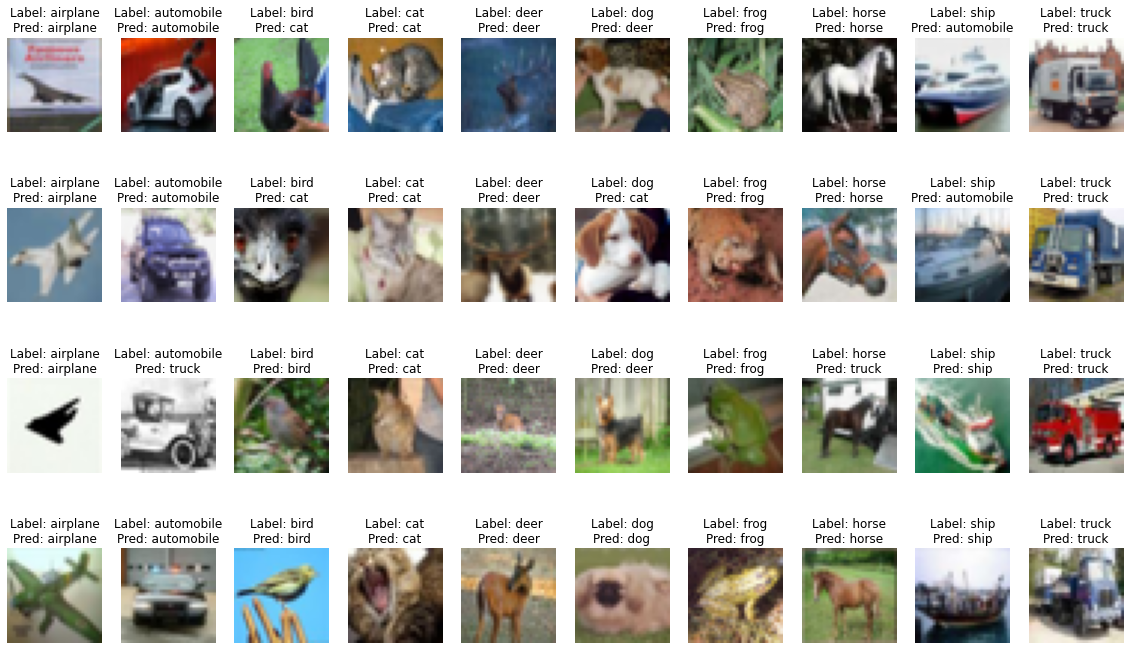

In [ ]:
################## TODO BLOCK

#Plot the first images in the dataset for each label
f, ax = plt.subplots(4, 10, figsize=(20, 12))
for i in range(10):
    count, j = 0, 0
    while count < 4:
        if np.argmax(y_test[j]) == i:
            ax[count, i].imshow(x_test[j])
            ax[count, i].set_title("Label: " + labels[i] + '\n' + "Pred: " + labels[np.argmax(y_pred[j])])
            ax[count, i].axis('off')
            count += 1
        j +=1


# Now, the predictions are almost perfect. We still have confusion between cat/dog.
# And the distinction between truck and automobile (that was tricky for the first CNN) is
# now much better.

################## END TODO BLOCK